## Introduction:
The goal of this project is to establish a robust intelligent system to aid in value investing efforts using stock market data. The system will help make investment decisions and based on intrinsic value of companies. It will not, however, trade on the basis of daily market volatility. This project is a part 4 of a series of 7 companies. At the end of the project we will be able to:


1.   Predict stock price valuations on a daily, weekly and monthly basis
2.   Recommend to buy, sell or hold based on certain decision parameters
3.   Maximize capital returns, minimise loses, and minise hold periods

## Loading Libraries And Data For South Africa Impala Platinum



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
df = pd.read_excel('/content/2020Q1Q2Q3Q4-2021Q1.xlsx', sheet_name='South Africa - Impala Platinum ')

## Data Wrangling

In [ ]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,27373,26980,27526,26657,2.49M,0.0177
1,2021-03-30 00:00:00,26898,26766,27443,26360,3.02M,-0.0030
2,2021-03-29 00:00:00,26980,27800,28174,26614,4.44M,-0.0201
3,2021-03-26 00:00:00,27533,27083,28006,26728,3.36M,0.0365
4,2021-03-25 00:00:00,26564,25954,27128,25954,2.83M,0.0255


In [ ]:
df.shape

(315, 7)

In [ ]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
310,2020-01-07 00:00:00,14500,14688,14688,13940,3.94M,-0.0082
311,2020-01-06 00:00:00,14620,14985,15045,14574,2.61M,-0.0150
312,2020-01-03 00:00:00,14843,14700,14884,14360,3.19M,0.0358
313,2020-01-02 00:00:00,14330,14525,14764,14325,2.01M,-0.0015
314,"Highest: 29,777","Lowest: 4,476","Difference: 25,301","Average: 16,018",Change %: 91,NaN,NaN


In [ ]:
df = df[:-1]

In [ ]:
df.dtypes

Date         object
Price        object
Open         object
High         object
Low          object
Vol.         object
Change %    float64
dtype: object

In [ ]:
df.isna().any()

Date        False
Price       False
Open        False
High        False
Low         False
Vol.        False
Change %    False
dtype: bool

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
def convert_volume(x):
    if x.endswith('K'):
        return float(x[:-1]) * 1000
    elif x.endswith('M'):
        return float(x[:-1]) * 1000000
    else:
        return float(x)

In [ ]:
df['Vol.'] = df['Vol.'].apply(convert_volume)

In [ ]:
for i in df.columns:
  if df[i].dtype == 'object':
    df[i] = df[i].astype(float)

# Exploratory Data Analysis

In [ ]:
df['Price'].describe()

count      314.000000
mean     16018.340764
std       4847.101782
min       5550.000000
25%      12591.250000
50%      15381.000000
75%      18330.250000
max      29138.000000
Name: Price, dtype: float64

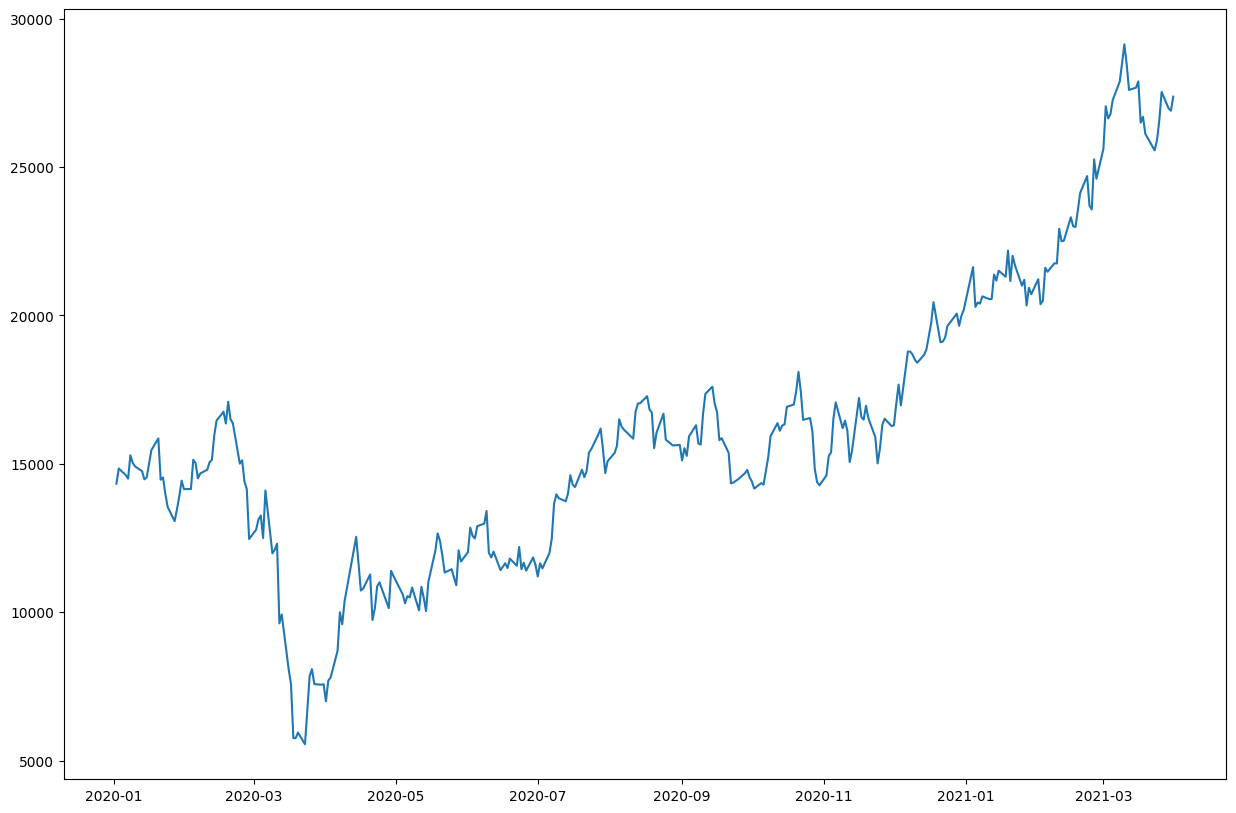

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df['Price'])
plt.show()

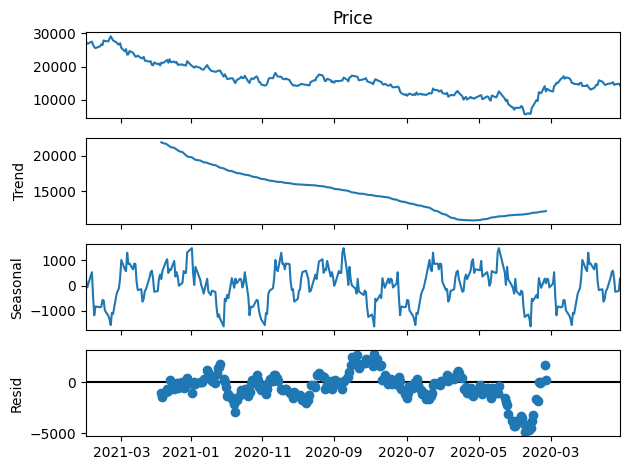

In [ ]:
decomp = seasonal_decompose(df['Price'], model='additive', period=90)
decomp.plot()
plt.show()

## Modeling And Preprocessing

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.072666
p-value: 0.255647
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


In [ ]:
def stationarity_check(value):
  if value < 0.05:
    print(f'Data is Stationary')
  else:
    print(f'Data is Non-Stationary')

In [ ]:
stationarity_check(result[1])

Data is Non-Stationary


In [ ]:
df['price_diff'] = df['Price'].diff().dropna()

In [ ]:
df['rolling_mean_diff'] = df['price_diff'].rolling(window=5).mean()
df.dropna(inplace=True)

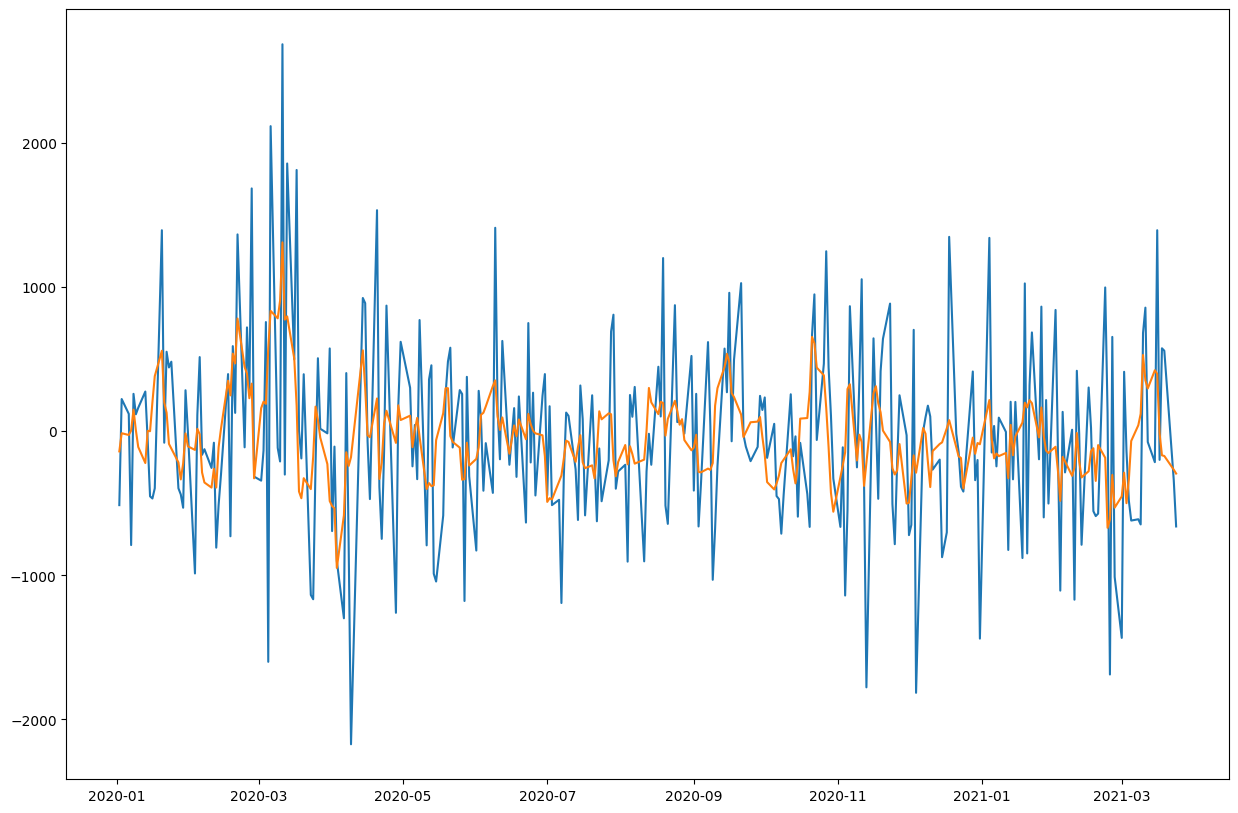

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df['price_diff'])
plt.plot(df['rolling_mean_diff'])
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
df_train = df['2020-01-01':'2021-01-01']
df_test = df['2021-01-01':]


## Creating The ARIMA Model

In [ ]:
def evaluate_arima_model(data, arima_order):
  train, test = df_train['rolling_mean_diff'].values, df_test['rolling_mean_diff'].values
  past = [x for x in train]
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(past, order=arima_order)
    model_fit = model.fit()
    future = model_fit.forecast()[0]
    predictions.append(future)
    past.append(test[t])
  error = mean_absolute_percentage_error(test, predictions)
  return error

## Finding The Besting Order For The ARIMA Model

In [ ]:
def evaluate_models(data, p_values, d_values, q_values):
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p, q, d)
        try:
          mpe = evaluate_arima_model(data, order)
          if mse < best_score:
            best_score, best_cfg = mse, order
          print('ARIMA%s MSE=%.3f' % (order, mse))
        except:
          continue
  return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [ ]:
#evaluate_models(df_train['rolling_mean_diff'].values, p_values, d_values, q_values)

In [ ]:
p = 1
d = 1
q = 1
model = ARIMA(df_train['rolling_mean_diff'], order=(p, d, q))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(df_test))

## Ploting Predictions

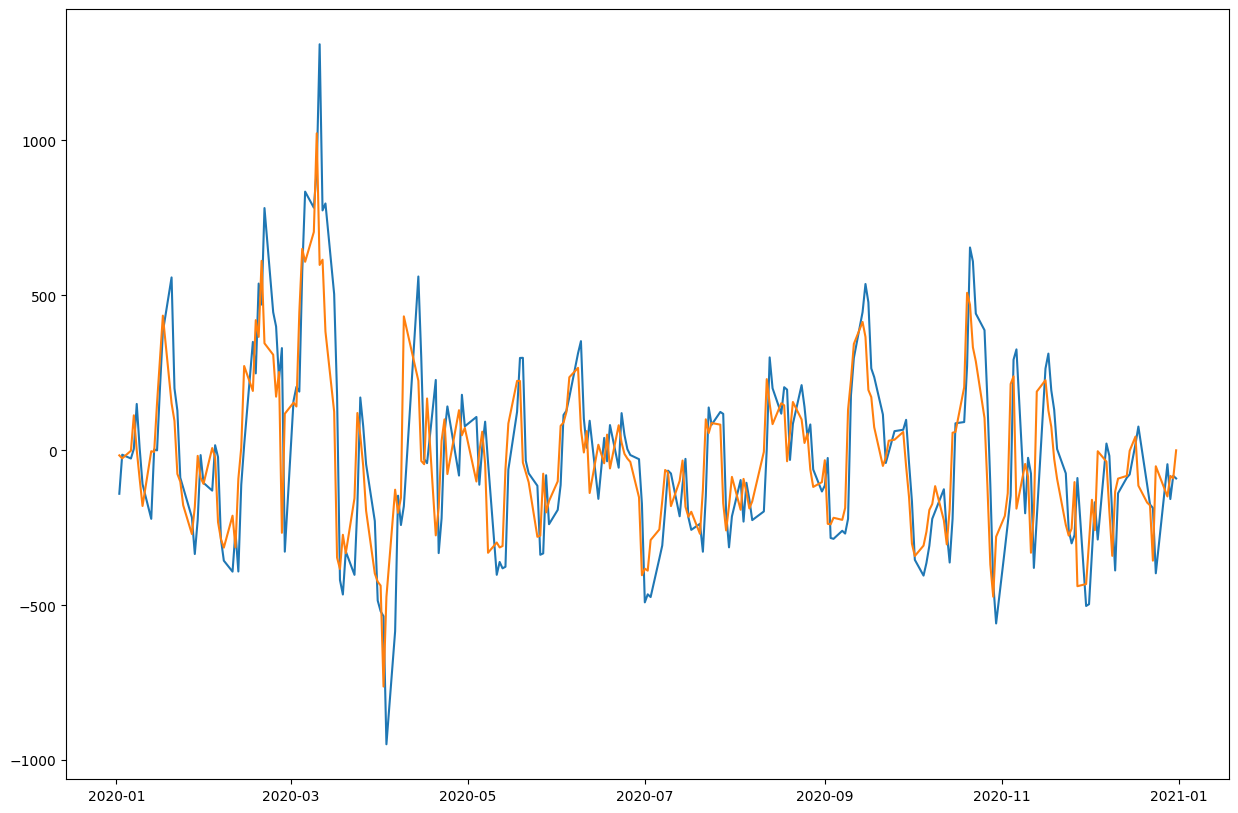

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df_train['rolling_mean_diff'])
plt.plot(model_fit.predict())
plt.show()

In [ ]:
future_cast = model_fit.forecast(len(df_test))
future_cast.index = df_test.index
future_cast = pd.DataFrame(future_cast)
future_cast.columns = ['rolling_mean_diff']

## Plotting The Forecasts

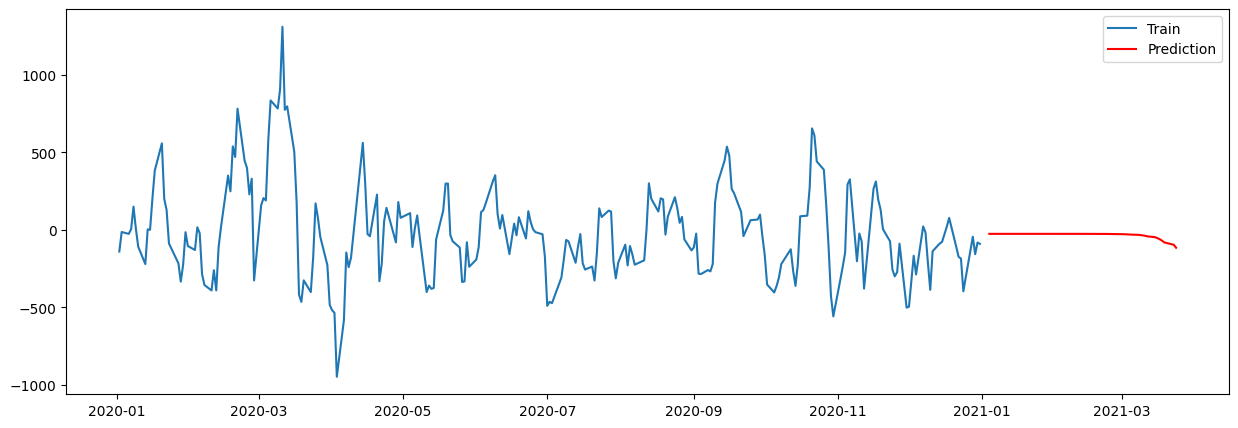

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df_train['rolling_mean_diff'], label='Train')
plt.plot(future_cast['rolling_mean_diff'], color='red', label='Prediction')
plt.legend()
plt.show()

## Back Testing The Model

In [ ]:
def evaluate_arima_model(data, arima_order, start_train_size):
    history = list(data[:start_train_size])
    predictions = []
    for t in range(start_train_size, len(data)):

        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast(7)[-1]
        predictions.append(future)
        history.append(data[t])
    mse = mean_squared_error(data[start_train_size:], predictions)
    mpe = mean_absolute_percentage_error(data[start_train_size:], predictions)

    return mse , mpe, predictions

In [ ]:
mse, mpe, predictions = evaluate_arima_model(df['rolling_mean_diff'].sort_index(), (1, 1, 1), len(df_train))

In [ ]:
forecast = pd.DataFrame(predictions)
forecast.columns = ['rolling_mean_diff']
forecast.index = df_test.index[::-1]
forecast.head()

,rolling_mean_diff
Date,
2021-01-04,-38.349665
2021-01-05,21.491017
2021-01-06,-26.619688
2021-01-07,-206.380154
2021-01-08,-140.546336


In [ ]:
f_std = forecast['rolling_mean_diff'].std()

## Ploting Forecasts With Bollinger Bands

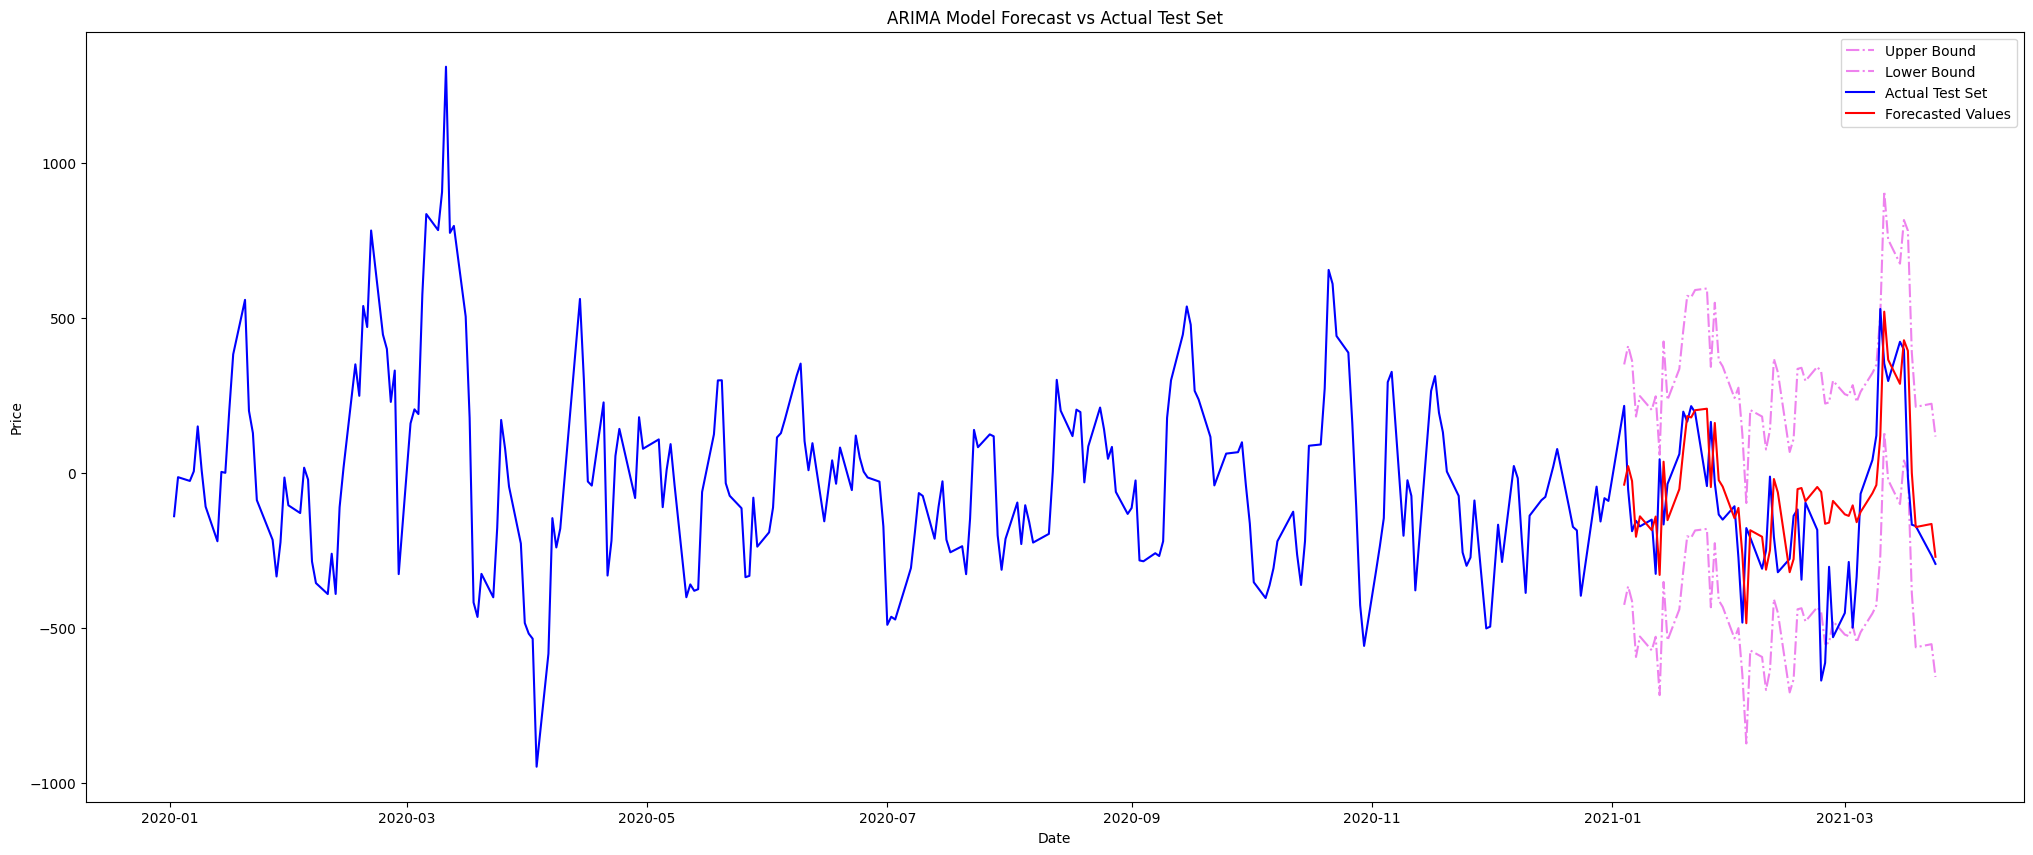

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(forecast['rolling_mean_diff'] + 1.96*f_std, label='Upper Bound', color='violet', linestyle='-.')
plt.plot(forecast['rolling_mean_diff'] - 1.96*f_std, label='Lower Bound', color='violet', linestyle='-.')

plt.plot(df['rolling_mean_diff'], label='Actual Test Set', color='blue')

plt.plot(forecast, label='Forecasted Values', color='red')

plt.title('ARIMA Model Forecast vs Actual Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
o_std = df['rolling_mean_diff'].std()

## Decisions: Buy, Sell, Or, Hold?



In [ ]:
def buy_sell_hold(forecast, look_ahead, data, threshold=1.96):
  standard_dev = data['rolling_mean_diff'].std()
  decisions = []
  open_prices = []
  dates = []
  buy_sell_flag = 'buy'
  for i in range(len(forecast) - look_ahead):
    if standard_dev is None:
      return "Please provide standard deviation"
    else:
      open_prices.append(data['Open'].iloc[i])
      dates.append(forecast.index[i])
      if (forecast.iloc[i + look_ahead] > forecast.iloc[i] + threshold * standard_dev) & (buy_sell_flag != 'buy'):
        decisions.append('buy')
        buy_sell_flag = 'buy'
      elif (forecast.iloc[i + look_ahead] < forecast.iloc[i] - threshold * standard_dev) & (buy_sell_flag != 'sell'):
        decisions.append('sell')
        buy_sell_flag = 'sell'
      else:
        decisions.append('hold')
  df = pd.DataFrame({'Decision': decisions, 'Open': open_prices}, index=dates)
  return df

In [ ]:
decision_df = buy_sell_hold(forecast['rolling_mean_diff'], look_ahead=7, data=df, threshold=0.1)

In [ ]:
decision_df.head()

,Decision,Open
2021-01-04,sell,25498.0
2021-01-05,hold,25800.0
2021-01-06,hold,26500.0
2021-01-07,buy,27250.0
2021-01-08,hold,27145.0


## Assessing Profit Based On Decision Parameters

In [ ]:
def decision_score(lst):
  score = 0
  for i in range(len(lst)):
    if lst[i] == 'buy':
      score += 1
    elif lst[i] == 'sell':
      score -= 1
    else:
      score += 0
  return score

In [ ]:
decision_score(decision_df['Decision'])

-1